# 3.0 Preprocessing

After analyzing our dataset in 2.0, we now attempt to clear up our dataset by removing unusable images and outliers.

### 1. Adding the libraries we need

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

### 2. Read in the feature dataset from the result of 2.0 notebook

In [2]:
directory = "../dataset-numpy/"

dataset = pd.read_csv(os.path.join(directory, '2.0 - features.csv'), delimiter=',', header=0)

dataset.describe(include='all')

,label,black_pixels,regions
count,1472,1472.000000,1472.00000
unique,12,NaN,NaN
top,ash,NaN,NaN
freq,164,NaN,NaN
mean,NaN,3034.644022,1.47962
std,NaN,2080.925709,1.19351
min,NaN,718.000000,0.00000
25%,NaN,2128.000000,1.00000
50%,NaN,2534.500000,1.00000
75%,NaN,3367.250000,2.00000


### 3. Remove unusable images

There are images that are just scribbles. There is no reason to do imputation on these images as they are not real images. We will remove them from the dataset.

We remove all images with more than 6 regions as no rune in our dataset has more than 6 regions.

In [3]:
dataset_cleaned = dataset.copy()

# Deal with outliers by removing elements with more than 6 regions
dataset_cleaned = dataset_cleaned[dataset_cleaned['regions'] < 7]

dataset_cleaned.describe(include='all')

,label,black_pixels,regions
count,1469,1469.000000,1469.000000
unique,12,NaN,NaN
top,ash,NaN,NaN
freq,164,NaN,NaN
mean,NaN,3017.848877,1.445201
std,NaN,2045.784614,0.844456
min,NaN,718.000000,0.000000
25%,NaN,2125.000000,1.000000
50%,NaN,2532.000000,1.000000
75%,NaN,3360.000000,2.000000


### 4. Group up the images by label with a dictionary

With this step we can create separate pandas dataframes for each label. This will make it easier to do the imputation on category level.

In [4]:
dataset_normalized = dataset_cleaned.copy()

unique_labels = dataset_normalized['label'].unique()

images_dict = {elem : pd.DataFrame() for elem in unique_labels }

for key in images_dict.keys():
    images_dict[key] = dataset_normalized[:][dataset_normalized.label == key]

print("Print the number of images for each label")
for label in images_dict:
    print(label, len(images_dict[label]))

Print the number of images for each label
joy 114
ash 164
spear 130
gift 126
oak 104
sun 103
need 138
elk-sedge 118
bow 144
serpent 108
tyr 110
wealth 110


### 5. Normalize outliers for holes

Where the num of regions is not the most common value for a label, we will replace it with the most common value for that label. We do this, because we want to do manual classification. It makes our classifier later on easier to write if each type of image has exactly the same amount of regions. This will make our classifier less complicated to implement.

In [5]:
for label, image_set in images_dict.items():
    print(f"Label: {label}")
    # get the most frequent 'hole' value for the label ash
    mode_holes = np.bincount(images_dict[label]['regions']).argmax()
    print(f'Mode regions: {mode_holes}')

    # Where the num of holes is not equal to the mode, replace the value with the mode
    images_dict[label]['regions'] = np.where(images_dict[label]['regions'] != mode_holes, mode_holes, images_dict[label]['regions'])
    print(images_dict[label].describe(include='all'))


Label: joy
Mode regions: 2
       label  black_pixels  regions
count    114    114.000000    114.0
unique     1           NaN      NaN
top      joy           NaN      NaN
freq     114           NaN      NaN
mean     NaN   2409.017544      2.0
std      NaN   1392.632631      0.0
min      NaN    863.000000      2.0
25%      NaN   2074.000000      2.0
50%      NaN   2280.000000      2.0
75%      NaN   2526.750000      2.0
max      NaN  16384.000000      2.0
Label: ash
Mode regions: 1
       label  black_pixels  regions
count    164    164.000000    164.0
unique     1           NaN      NaN
top      ash           NaN      NaN
freq     164           NaN      NaN
mean     NaN   2458.701220      1.0
std      NaN   1640.305842      0.0
min      NaN   1111.000000      1.0
25%      NaN   1989.250000      1.0
50%      NaN   2252.500000      1.0
75%      NaN   2533.000000      1.0
max      NaN  16384.000000      1.0
Label: spear
Mode regions: 3
        label  black_pixels  regions
count     130   

We now hame the same amount of regions for each category.

### 6. Remove outliers for num of black pixels

With our boxplots in our feature analysis, we found a lot of outliers in our `sum of black pixels` dataset. We remove all outliers that fall out 50% of the IQR.

In [6]:
for label, image_set in images_dict.items():
    q1 = image_set['black_pixels'].quantile(0.25) # 25th percentile
    q3 = image_set['black_pixels'].quantile(0.75) # 75th percentile
    iqr = q3 - q1 # Interquartile range (IQR)
    fence_low = q1 - (1.5 * iqr) # Lower bound for outliers (anything below this value is an outlier)
    fence_high = q3 + (1.5 * iqr) # Upper bound for outliers (anything above this value is an outlier)
    image_set = image_set[~((image_set['black_pixels'] < fence_low) | (image_set['black_pixels'] > fence_high))] # Remove outliers from the dataset
    images_dict[label] = image_set # Update the dictionary


### 7. Show the preprocessed data

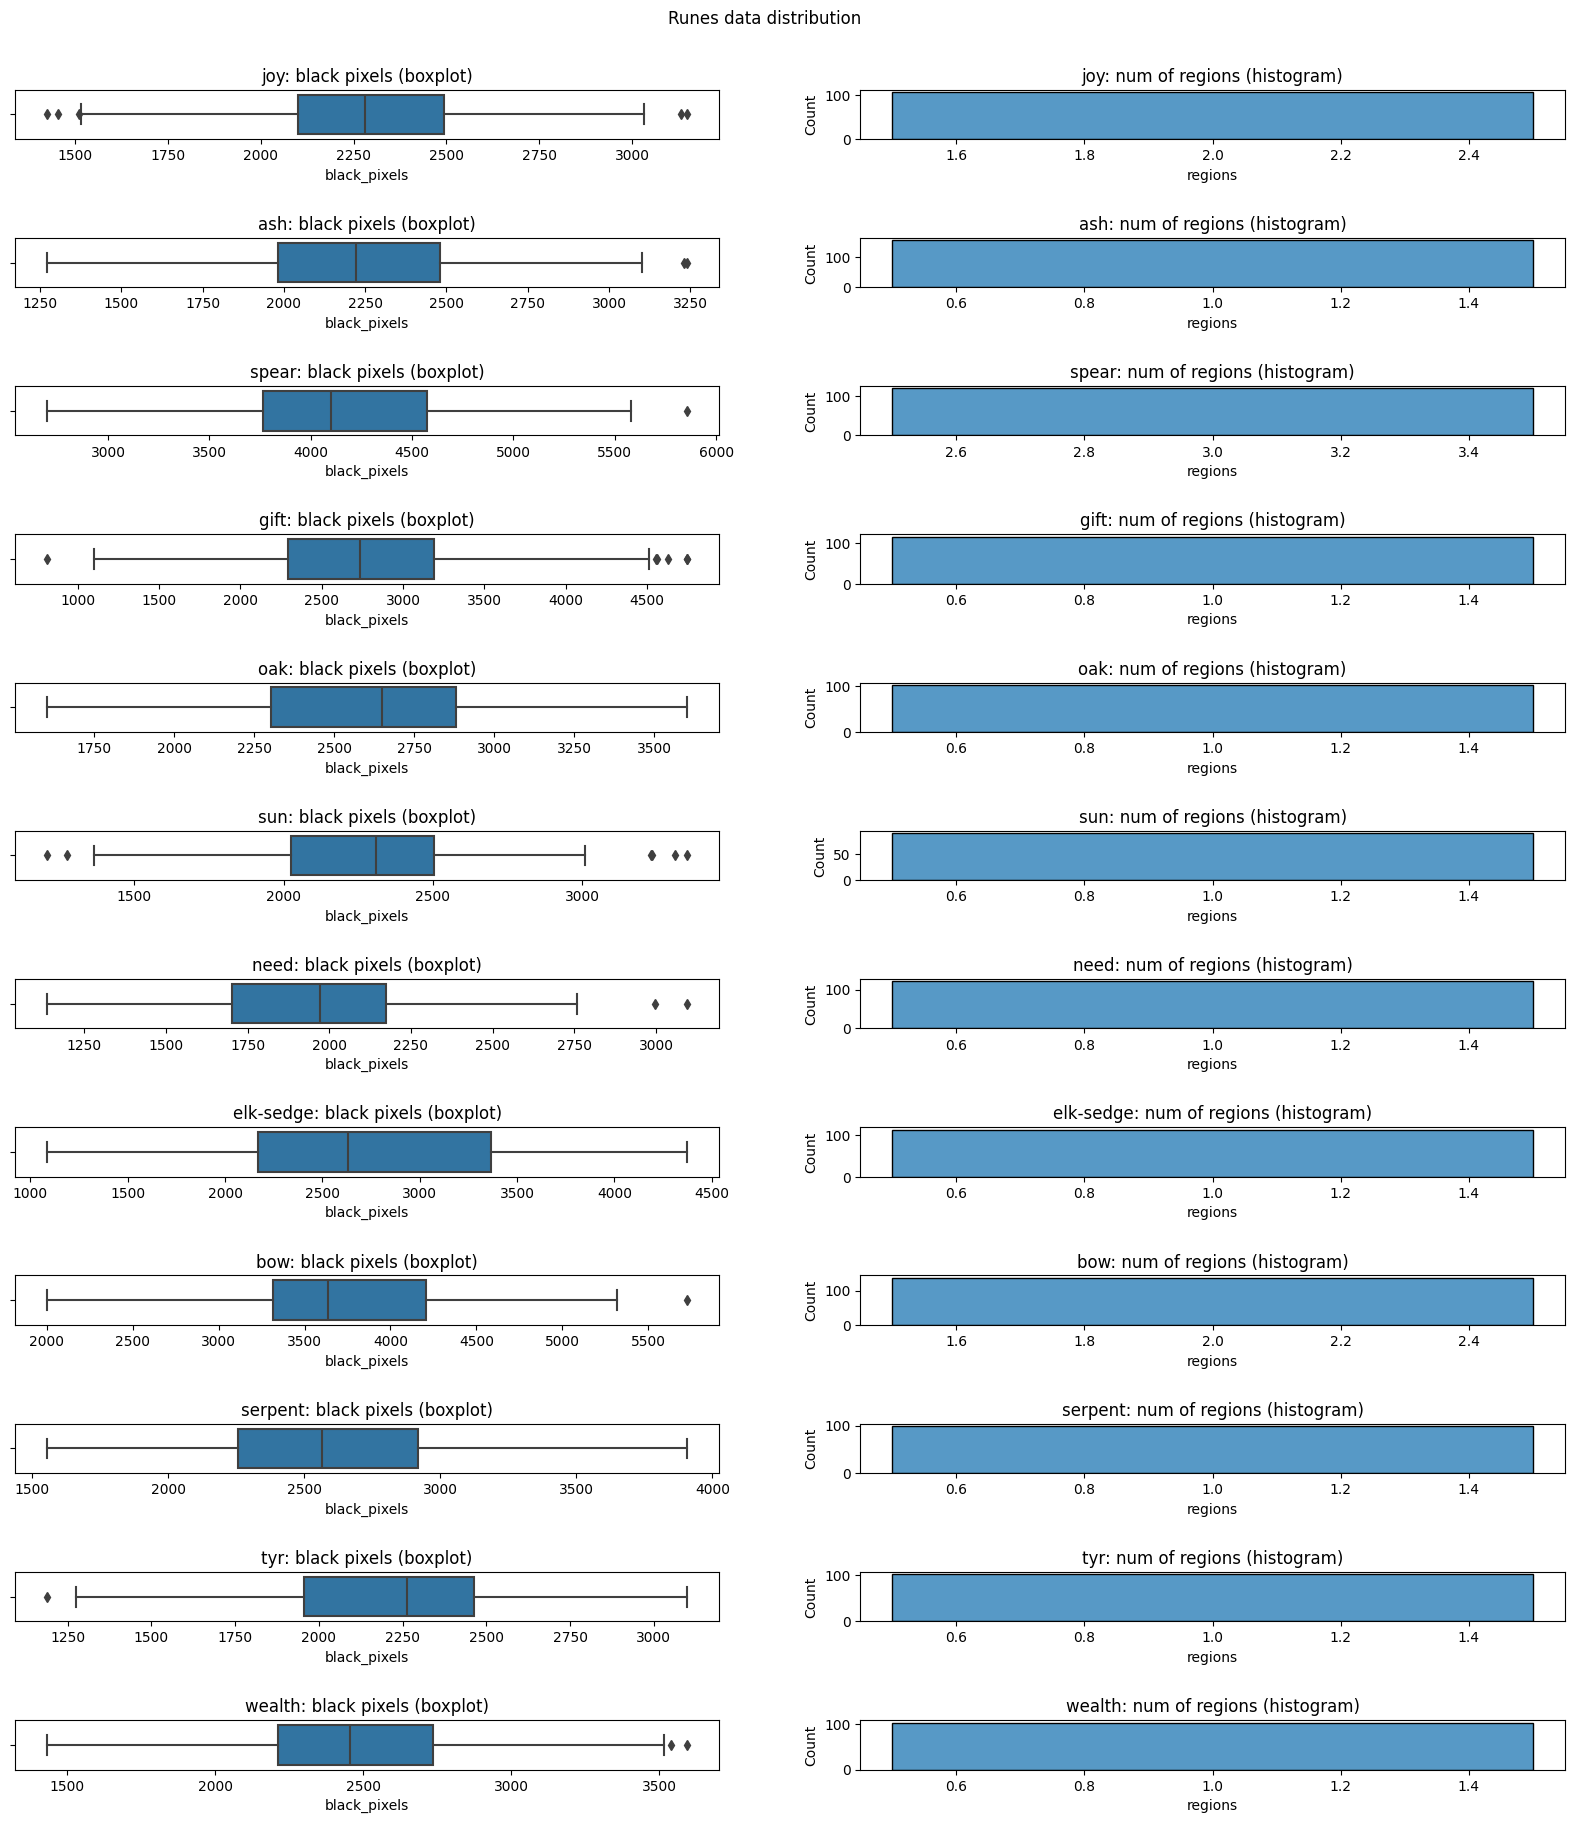

In [7]:
fig, ax = plt.subplots(nrows=len(images_dict.keys()), ncols=2, figsize=(20, 20)) # 2 for holes and pixels
fig.suptitle('Runes data distribution')

for i, (label, image_set) in enumerate(images_dict.items()):
    ax[i][0].set_title(f'{label}: black pixels (boxplot)')
    ax[i][1].set_title(f'{label}: num of regions (histogram)')
    sns.boxplot(data=image_set, ax=ax[i][0], x='black_pixels')
    sns.histplot(data=image_set, ax=ax[i][1], x='regions')

fig.subplots_adjust(hspace=2, top=0.94, bottom=0.1)

### 8. Save the data

We create a new dataset with out cleaned data.

In [8]:
# make csv file
directory = "../dataset-numpy/" 
path = os.path.join(directory, '3.0 - features.csv')
with open(path, 'w', newline='') as f:
    # Print csv header
    print("label,black_pixels,regions", file=f)
    # Print csv rows
    for label, image_set in images_dict.items():
        for index, row in image_set.iterrows():
            print(f"{row['label']},{row['black_pixels']},{row['regions']}", file=f)